<a href="https://colab.research.google.com/github/ciastirfry/Quantum_Computing/blob/main/task2a_qiskit_circuit_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSE802 – Assessment 2, Task 2A (Qiskit Circuit)

###Author’s Name : Fredierick Saladas
###Student ID : 270609973@yoobeestudent.ac.nz
###College : Yoobee College of Creative Innovation
###Course : MSE802 Quantum Computing
###Supervisor : Dr. Arun Kumar
####Date : 15 November 2025

**Goal:** Build the specified circuit using Qiskit and run both locally (Aer) and via Quokka (starter pattern).  
Circuit: **H on q0**, **X on q1**, then **CNOT q0 → q1**, measure all.

**Colab Setup:**

In [1]:
# Step 0: Install Qiskit (Colab runtime)
!pip -q install qiskit==1.2.4 qiskit-aer==0.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 11.5 MB/s eta 0:00:00


### OpenQASM 2.0 Helpers (Qiskit 1.x)

Qiskit 1.x removed `QuantumCircuit.qasm()`.  
Use `qiskit.qasm2.dumps(circuit)` to export and `qiskit.qasm2.loads(text)` (or `load(file)`) to import.
Below we provide small wrappers for convenience and backward-compatibility.


In [2]:
# QASM2 helper functions
try:
    from qiskit import qasm2
except Exception as _e:
    qasm2 = None

def to_qasm2(circ):
    """Return OpenQASM 2.0 string for a circuit in Qiskit 1.x+.
    Falls back to old .qasm() if available (older Qiskit).
    """
    if qasm2 is not None:
        return qasm2.dumps(circ)
    # fallback for older versions (<1.0)
    if hasattr(circ, "qasm"):
        return circ.qasm()
    raise RuntimeError("No QASM exporter available. Please install Qiskit>=1.0 or downgrade to 0.46.x.")

def from_qasm2_text(text):
    """Parse OpenQASM 2.0 string into a QuantumCircuit in Qiskit 1.x+.
    Falls back to QuantumCircuit.from_qasm_str for older versions.
    """
    from qiskit import QuantumCircuit
    if qasm2 is not None:
        return qasm2.loads(text)
    if hasattr(QuantumCircuit, "from_qasm_str"):
        return QuantumCircuit.from_qasm_str(text)
    raise RuntimeError("No QASM2 loader available. Install Qiskit>=1.0 or use an older API.")


### Drawer Dependencies (Matplotlib)
Install extras required for `qc.draw('mpl')`.

In [3]:
# Install the Matplotlib drawer dependencies
!pip -q install pylatexenc matplotlib
%matplotlib inline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
# Step 1: Imports
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.primitives import Sampler
import matplotlib.pyplot as plt
import numpy as np
import json

import requests, warnings
warnings.filterwarnings('ignore')

### Quokka Access (from attached pattern)

The helper below mirrors the *exact* submission style from the provided Quokka access notebook:
- Endpoint: `http://quokka1.quokkacomputing.com/qsim/qasm`
- Headers: `{"Content-Type": "application/json"}`
- Body shape: `script_count`


In [5]:
# Helper that mirrors the attached Quokka access notebook
import json, requests

QUOKKA_ENDPOINT = "http://quokka1.quokkacomputing.com/qsim/qasm"
DEFAULT_HEADERS = {"Content-Type": "application/json"}

def quokka_submit(qasm_source: str, shots: int = 1024, headers: dict = None):
    if headers is None:
        headers = DEFAULT_HEADERS
    payload = {"script": qasm_source, "count": int(shots)}
    r = requests.post(QUOKKA_ENDPOINT, json=payload, headers=headers, verify=False, timeout=120)
    try:
        return r.json()
    except Exception:
        return {"raw_text": r.text, "status_code": r.status_code}


## Build the Task 2A Circuit

- Qubits: 2 (q0, q1)
- Gates: H on q0, X on q1, CNOT(q0 → q1)
- Measure all qubits into classical bits

In [6]:
# Step 2: Construct circuit (modular functions + comments)

def build_task2a_circuit():
    """Builds the required 2-qubit circuit:
    - H on q0
    - X on q1
    - CNOT(q0 -> q1)
    - measure all qubits
    """
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.x(1)
    qc.cx(0, 1)
    qc.measure([0,1], [0,1])
    return qc

qc2a = build_task2a_circuit()
qc2a

## Visualize the Circuit

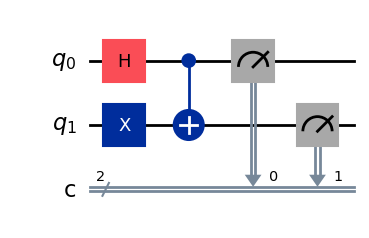

In [7]:
qc2a.draw('mpl')

## Local Execution (Aer Simulator)

We run the circuit locally with **Qiskit Aer** and display counts and a histogram.

Local counts: {'01': 997, '10': 1051}


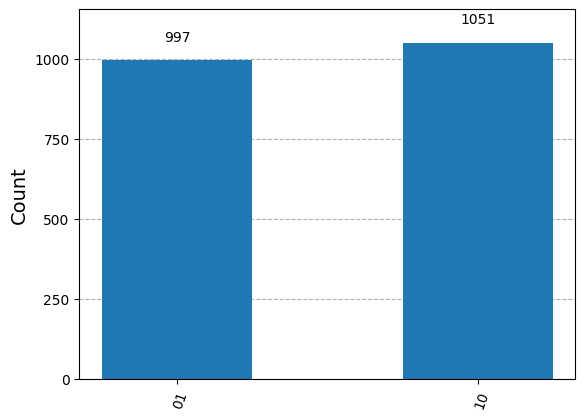

In [8]:
backend = Aer.get_backend('qasm_simulator')
shots = 2048
job = backend.run(qc2a, shots=shots)
result = job.result()
counts_local = result.get_counts(qc2a)
print('Local counts:', counts_local)
plot_histogram(counts_local)

### Quokka Helper

Reusable helper for sending **OpenQASM 2.0** to Quokka (`{'script': qasm, 'count': shots}`) at `http://quokka1.quokkacomputing.com/qsim/qasm`. Add auth headers if required.

In [9]:
import json, requests

def quokka_submit(qasm_source: str, shots: int = 1024, endpoint: str = 'http://quokka1.quokkacomputing.com/qsim/qasm', headers: dict = None):
    if headers is None:
        headers = {'Content-Type': 'application/json'}
    data = {'script': qasm_source, 'count': int(shots)}
    try:
        resp = requests.post(endpoint, json=data, headers=headers, verify=False, timeout=120)
        status = resp.status_code
        try:
            payload = resp.json()
        except Exception:
            payload = {'raw_text': resp.text}
        print(f'[Quokka] Status: {status}')
        return payload
    except Exception as e:
        print('[Quokka] Error:', repr(e))
        return {'error': str(e)}

## Send to Quokka (Starter Pattern)

Convert the Qiskit circuit to **OpenQASM 2.0** and send to Quokka.

In [10]:
qasm_2a = to_qasm2(qc2a)
print(qasm_2a.splitlines()[:10])
quokka_resp_2a = quokka_submit(qasm_2a, shots=1024)
print(json.dumps(quokka_resp_2a, indent=2)[:1200])

['OPENQASM 2.0;', 'include "qelib1.inc";', 'qreg q[2];', 'creg c[2];', 'h q[0];', 'x q[1];', 'cx q[0],q[1];', 'measure q[0] -> c[0];', 'measure q[1] -> c[1];']
[Quokka] Status: 200
{
  "error": "no error",
  "error_code": 0,
  "result": {
    "c": [
      [
        1,
        0
      ],
      [
        1,
        0
      ],
      [
        0,
        1
      ],
      [
        1,
        0
      ],
      [
        0,
        1
      ],
      [
        1,
        0
      ],
      [
        1,
        0
      ],
      [
        1,
        0
      ],
      [
        0,
        1
      ],
      [
        1,
        0
      ],
      [
        0,
        1
      ],
      [
        1,
        0
      ],
      [
        0,
        1
      ],
      [
        0,
        1
      ],
      [
        1,
        0
      ],
      [
        1,
        0
      ],
      [
        0,
        1
      ],
      [
        0,
        1
      ],
      [
        0,
        1
      ],
      [
        0,
        1

## Interpret/Visualize Quokka Results (if counts available)

In [11]:
from collections import Counter

def try_extract_counts(obj):
    if isinstance(obj, dict):
        if 'counts' in obj and isinstance(obj['counts'], dict):
            return {str(k): int(v) for k,v in obj['counts'].items()}
        if 'results' in obj and isinstance(obj['results'], dict) and 'counts' in obj['results']:
            return {str(k): int(v) for k,v in obj['results']['counts'].items()}
    if isinstance(obj, list):
        return dict(Counter([str(x) for x in obj]))
    return None

counts_quokka_2a = try_extract_counts(quokka_resp_2a)
if counts_quokka_2a:
    print('Quokka counts:', counts_quokka_2a)
    plot_histogram(counts_quokka_2a)
else:
    print('No parseable counts returned from Quokka.')

No parseable counts returned from Quokka.


### Interpretation (Part 2A)

- H on q0 makes superposition; X on q1 flips to |1⟩; CNOT(q0→q1) correlates states.
- Expect correlated outputs depending on initial X and entangling action.
- Local vs. Quokka histograms should qualitatively agree.

## (Optional) Quokka Async Poller

Some deployments return a `job_id` and require polling. This helper tries both patterns:
1) Immediate JSON with `counts`
2) `job_id` → poll `/jobs/<id>` until `SUCCEEDED`

If your service uses another path, tweak `STATUS_PATH` accordingly.


In [12]:
import time, requests, json

def quokka_submit_or_poll(qasm_source: str, shots: int = 1024,
                          endpoint: str = "http://quokka1.quokkacomputing.com/qsim/qasm",
                          headers: dict = None,
                          status_path_template: str = "http://quokka1.quokkacomputing.com/jobs/{job_id}"):
    if headers is None:
        headers = {"Content-Type": "application/json"}
    data = {"script": qasm_source, "count": int(shots)}
    r = requests.post(endpoint, json=data, headers=headers, verify=False, timeout=120)
    try:
        j = r.json()
    except Exception:
        return {"status_code": r.status_code, "raw_text": r.text}

    # Case 1: counts already present
    if isinstance(j, dict) and ("counts" in j or ("results" in j and isinstance(j["results"], dict) and "counts" in j["results"])):
        return j

    # Case 2: async job id
    job_id = j.get("job_id") or j.get("id")
    if not job_id:
        return j  # unknown shape; return as-is for inspection

    status_url = status_path_template.format(job_id=job_id)
    deadline = time.time() + 180
    while time.time() < deadline:
        s = requests.get(status_url, headers=headers, verify=False, timeout=60)
        try:
            sj = s.json()
        except Exception:
            return {"poll_raw_text": s.text, "status_url": status_url}

        state = (sj.get("state") or sj.get("status") or "").upper()
        if state in {"SUCCEEDED", "COMPLETED", "DONE"}:
            return sj.get("result") or sj.get("results") or sj
        if state in {"FAILED", "CANCELLED", "ERROR"}:
            return {"error": f"Job {job_id} ended with state={state}", "full": sj}
        time.sleep(2.0)
    return {"error": "Timeout waiting for job", "job_id": job_id, "status_url": status_url}
